<a href="https://colab.research.google.com/github/DecianyMoura/model_deep_Q-learning/blob/main/exemploDeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Importação de bibliotecas
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video

In [ ]:
# Definição da rede neural (Q-network)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Parâmetros
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
memory = deque(maxlen=2000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Modelos
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [ ]:
# Funções auxiliares
def act(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        return policy_net(state).argmax().item()

def replay():
    global epsilon
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach()
    target = rewards + (gamma * next_q_values * (1 - dones))

    loss = nn.MSELoss()(q_values.squeeze(), target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


In [ ]:
# Treinamento
episodes = 300
scores = []

for e in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = act(state, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        replay()
    scores.append(total_reward)

    if e % 20 == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print(f"Episode {e}/{episodes} - Score: {total_reward}")

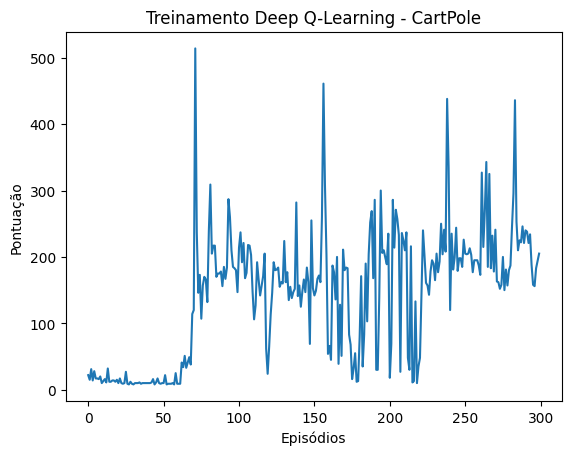

In [ ]:
# Gráfico de recompensas
plt.plot(scores)
plt.xlabel("Episódios")
plt.ylabel("Pontuação")
plt.title("Treinamento Deep Q-Learning - CartPole")
plt.show()

In [26]:
# Criação do ambiente para capturar os frames
env = gym.make("CartPole-v1", render_mode="rgb_array")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Função para gravar video do agente treinado
def save_agent_video(env, policy_net, filename="cartpole_agent.mp4", episodes=3):
    frames = []
    for ep in range(episodes):
        state, info = env.reset()
        done = False
        truncated = False
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = policy_net(state_tensor).argmax().item()

            next_state, reward, done, truncated, info = env.step(action)

            frame = env.render()
            if frame is not None and isinstance(frame, np.ndarray):
                frames.append(frame)

            state = next_state

    imageio.mimsave(filename, frames, fps=30)
    print(f"Vídeo salvo em: {filename}")
    return Video(filename, embed=True)



In [ ]:
# Exibe em video os framers do agente
save_agent_video(env, policy_net)